In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU_MITB_NLP/Group Project/NLP-Lyric-Generator/src/bin

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SMU_MITB_NLP/Group Project/NLP-Lyric-Generator/src/bin


In [2]:
!pip install aitextgen
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 572 kB 16.1 MB/s 
     |████████████████████████████████| 4.4 MB 59.5 MB/s 
     |████████████████████████████████| 87 kB 9.2 MB/s 
     |████████████████████████████████| 585 kB 15.7 MB/s 
     |████████████████████████████████| 419 kB 46.4 MB/s 
     |████████████████████████████████| 140 kB 7.5 MB/s 
     |████████████████████████████████| 596 kB 29.7 MB/s 
     |████████████████████████████████| 1.1 MB 14.6 MB/s 
     |████████████████████████████████| 6.6 MB 34.4 MB/s 
     |████████████████████████████████| 86 kB 3.0 MB/s 
     |████████████████████████████████| 271 kB 53.6 MB/s 
     |████████████████████████████████| 144 kB 75.2 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
  Created wheel for aitextgen: filename=aitextgen-0.5.2-py3-none-any.whl size=575905 sha256=015fd8709c63d79b2c3625040df533edbd34c2cf153524eb48dc48dcd6ee9a

In [3]:
from aitextgen import aitextgen
from aitextgen.TokenDataset import TokenDataset, merge_datasets
from pytorch_lightning.loggers import TensorBoardLogger

In [4]:
### Standard Imports
import os
import sys
import torch
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim import downloader

In [5]:
### Custom Imports
sys.path.append('../')
import lib.utilities as utils
import lib.sentiment as sentiment

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [6]:
### Text Parameters
start_token = '<cls>'
end_token = '<eos>'
pad_token = '<pad>'
unk_token = '<unk>'
newline_token = '<new>'
neu_token = '<neu>'
pos_token = '<pos>'

### General Parameters
random_seed = 42
model_folder = '../../../gpt2/finetuned/v3'
model_name = 'gpt2_ft_sent'

### Model Parameters
batch_size = 64
epochs = 30
sentiment_themes = ['unity', 'affection', 'aspiration', 'home', 'relationship', 'motivation', 'nationhood', 'life', 'celebrate']

In [7]:
os.makedirs(model_folder, exist_ok=True)

In [8]:
### Embeddings for Sentiment Analysis
glove_vectors = downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [9]:
### Load Data
corpus = utils.load_corpus()
train_corpus, val_corpus, train_files, val_files = utils.split_corpus()
songs = utils.split_text(corpus)[:-1]
train_songs = utils.split_text(train_corpus)[:-1]
val_songs = utils.split_text(val_corpus)[:-1]

In [10]:
### Scoring Songs for Sentiment
vader_scores = []
sentiment_theme_scores = []
for song in songs:
    sentiment_scorer = sentiment.Sentiment()
    sentiment_scorer.clean_text(original_text = 'placeholder', generated_text = song)
    sentiment_scorer.get_theme_vector(sentiment_themes, embedding = glove_vectors, topn=10)
    sentiment_scorer.score_vader_sentiment()
    sentiment_scorer.score_word_vector_sentiment()
    vader_scores.append(sentiment_scorer.vader_sentiment_scores['generated'])
    sentiment_theme_scores.append(sentiment_scorer.word_vector_sentiment_scores['generated'])

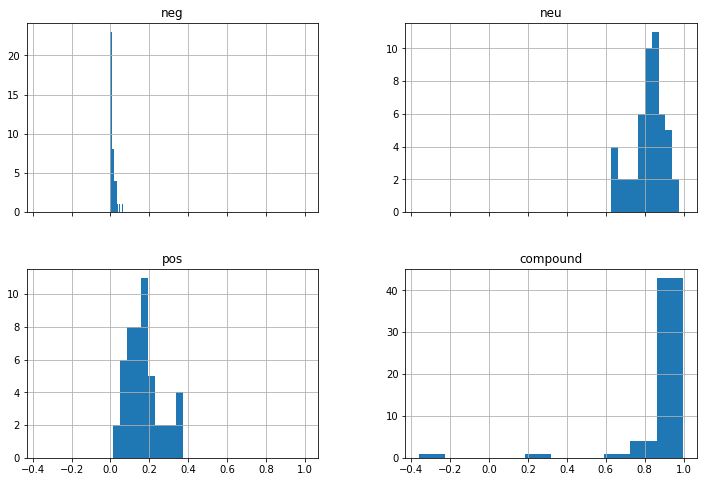

In [11]:
vader_df = pd.DataFrame(vader_scores)
vader_df.hist(figsize = (12,8), sharex = True)
plt.show()
# There is negligible variety of sentiment in the entire corpus

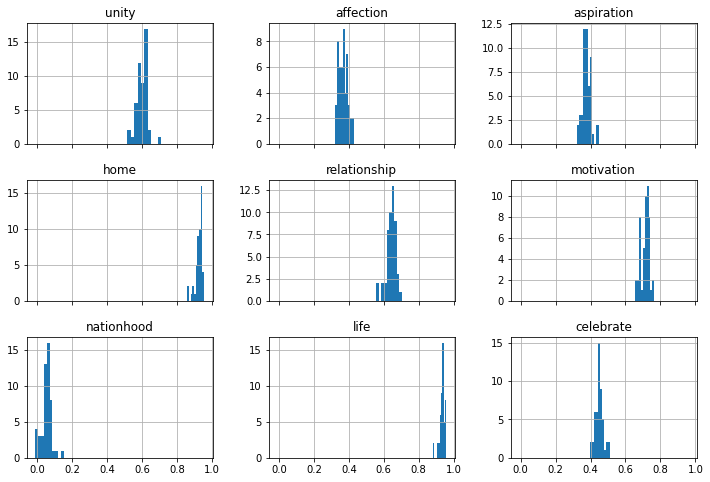

In [12]:
sentiment_theme_df = pd.DataFrame(sentiment_theme_scores)
sentiment_theme_df.hist(figsize = (12,8), sharex = True)
plt.show()
# There is negligible variety of sentiment in the entire corpus

In [13]:
### For illlustrative purposes, we will use the mean positive value as the cutoff between a <neu> and <pos> context label.
avg_pos = vader_df['pos'].mean()
train_words = []
for i, song in enumerate(train_songs):
    sentiment_scorer = sentiment.Sentiment()
    sentiment_scorer.clean_text(original_text = 'placeholder', generated_text = song)
    #sentiment_scorer.get_theme_vector(sentiment_themes, embedding = glove_vectors, topn=10)
    sentiment_scorer.score_vader_sentiment()
    pos_test = sentiment_scorer.vader_sentiment_scores['generated']['pos'] > avg_pos
    #words = utils.tokenize_text(song, newline_token)
    if pos_test:
        #train_words.append([pos_token] + words)
        train_songs[i] = pos_token + song
    else:
        #train_words.append([neu_token] + words)
        train_songs[i] = neu_token + song

In [14]:
traindata = TokenDataset(texts = train_songs,
                         line_by_line = True,
                         block_size = 1024,
                         bos_token = start_token,
                         eos_token = end_token,
                         unk_token = unk_token,
                         pad_token = pad_token)

  0%|          | 0/40 [00:00<?, ?it/s]

In [15]:
### Loading Model
hf_model = "gpt2"
ai = aitextgen(model=hf_model, to_gpu = True, verbose=True)
#ai.to_gpu()
out_dir = model_folder

https://huggingface.co/gpt2/resolve/main/config.json not found in cache or force_download set to True, downloading to /content/drive/MyDrive/SMU_MITB_NLP/Group Project/NLP-Lyric-Generator/src/bin/aitextgen/tmplnkbw9la


Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

storing https://huggingface.co/gpt2/resolve/main/config.json in cache at aitextgen/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
creating metadata file for aitextgen/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
loading configuration file https://huggingface.co/gpt2/resolve/main/config.json from cache at aitextgen/fc674cd6907b4c9e933cb42d67662436b89fa9540a1f40d7c919d0109289ad01.7d2e0efa5ca20cef4fb199382111e9d3ad96fd77b849e1d4bed13a66e1336f51
Model config GPT2Config {
  "_name_or_path": "gpt2",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "

Downloading:   0%|          | 0.00/523M [00:00<?, ?B/s]

storing https://huggingface.co/gpt2/resolve/main/pytorch_model.bin in cache at aitextgen/752929ace039baa8ef70fe21cdf9ab9445773d20e733cf693d667982e210837e.323c769945a351daa25546176f8208b3004b6f563438a7603e7932bae9025925
creating metadata file for aitextgen/752929ace039baa8ef70fe21cdf9ab9445773d20e733cf693d667982e210837e.323c769945a351daa25546176f8208b3004b6f563438a7603e7932bae9025925
loading weights file https://huggingface.co/gpt2/resolve/main/pytorch_model.bin from cache at aitextgen/752929ace039baa8ef70fe21cdf9ab9445773d20e733cf693d667982e210837e.323c769945a351daa25546176f8208b3004b6f563438a7603e7932bae9025925
All model checkpoint weights were used when initializing GPT2LMHeadModel.

All the weights of GPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GPT2LMHeadModel for predictions without further training.


In [16]:
steps = int(epochs * len(traindata) / batch_size) #5000 steps is about 30 epochs for this dataset
print(steps)

5510


In [17]:
ai.train(
    traindata,
    n_gpu = 1,
    num_steps = steps,
    generate_every = 10000,
    output_dir = out_dir,
    loggers = [TensorBoardLogger(out_dir)],
    freeze_layers = True,
    num_layers_freeze = 9,
    line_by_line = True,
    header = False,
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=20)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/usr/local/lib/python3.7/dist-packages/pytorch_lightn

  0%|          | 0/5510 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:2282: LightningDeprecationWarning: `trainer.progress_bar_dict` is deprecated in v1.5 and will be removed in v1.7. Use `ProgressBarBase.get_metrics` instead.
  "`trainer.progress_bar_dict` is deprecated in v1.5 and will be removed in v1.7."
Configuration saved in ../../../gpt2/finetuned/v3/config.json


1,000 steps reached: saving model to /../../../gpt2/finetuned/v3


Model weights saved in ../../../gpt2/finetuned/v3/pytorch_model.bin
Configuration saved in ../../../gpt2/finetuned/v3/config.json


2,000 steps reached: saving model to /../../../gpt2/finetuned/v3


Model weights saved in ../../../gpt2/finetuned/v3/pytorch_model.bin
Configuration saved in ../../../gpt2/finetuned/v3/config.json


3,000 steps reached: saving model to /../../../gpt2/finetuned/v3


Model weights saved in ../../../gpt2/finetuned/v3/pytorch_model.bin
Configuration saved in ../../../gpt2/finetuned/v3/config.json


4,000 steps reached: saving model to /../../../gpt2/finetuned/v3


Model weights saved in ../../../gpt2/finetuned/v3/pytorch_model.bin
Configuration saved in ../../../gpt2/finetuned/v3/config.json


5,000 steps reached: saving model to /../../../gpt2/finetuned/v3


Model weights saved in ../../../gpt2/finetuned/v3/pytorch_model.bin
Configuration saved in ../../../gpt2/finetuned/v3/config.json
Model weights saved in ../../../gpt2/finetuned/v3/pytorch_model.bin


In [23]:
prompts = ['Whenever I think back', 'And so this I know',
           'I am tired of being what you want me to be', 'Feeling so faithless, lost under the surface',
           'Relight our fire, we will find our way', 'We will rise stronger together']
pos_result_strings = {}
neu_result_strings = {}
for prompt in prompts:
    output = ai.generate(
        prompt = pos_token+'<VERSE>'+prompt,
        n = 1,
        min_len = 100,
        max_len = 500,
        temperature = 1,
        do_sample = True,
        use_cache = True,
        early_stopping = False,
        num_beams = 1,
        top_k = 50,
        top_p = 0.75,
        repetition_penalty = 1.2,
        length_penalty = 1.0,
        no_repeat_ngram_size = 0,
        num_beam_groups = 1,
        diversity_penalty = 0.0,
        remove_invalid_values = True,
        return_as_list = True,
        lstrip = False,
        skip_special_tokens = True
    )
    pos_result_strings[prompt] = output[0]
    
    output = ai.generate(
        prompt = neu_token+'<VERSE>'+prompt,
        n = 1,
        min_len = 100,
        max_len = 500,
        temperature = 1,
        do_sample = True,
        use_cache = True,
        early_stopping = False,
        num_beams = 1,
        top_k = 50,
        top_p = 0.75,
        repetition_penalty = 1.2,
        length_penalty = 1.0,
        no_repeat_ngram_size = 0,
        num_beam_groups = 1,
        diversity_penalty = 0.0,
        remove_invalid_values = True,
        return_as_list = True,
        lstrip = False,
        skip_special_tokens = True
    )
    neu_result_strings[prompt] = output[0]

In [24]:
print(pos_result_strings)
print(neu_result_strings)

{'Whenever I think back': "<pos><VERSE>Whenever I think back\nThe future it can be\nThe time has come for me\nTo strive and to achieve\nWith hopes within our hearts\nAs one hand in hand\nFor family and our friends\nLet's do the best we can\n\n<CHORUS>\nLet's reach out for the skies\nWith wings we soar up high\nOur dreams we'll all achieve\nWe'll make our destiny\nLet's reachout for the skies\nOur dreams we will always be\nShining as one\n\n<VERSE>\nWhen I think about my dreams\nThe future it will bring\nThis is my challenge, this is where I know it\n\n<CHORSUS>\nI want to sing\nSing a song for Singapore\nWith every generation there's more to be grateful for\nSo come and sing\nSing a songs for Singapore\nYou're my brother you're my sister\nI'm thankful for my Singapore\nMy Singapore\nSingapore\n\n<BRIDGE>\nWe've had our ups and downs\nSometimes the best things are taken for granted\nYou're my family you're my home\n\n<CHOREDUS>\nI wish to sing\nSing an song for Singapore\nThere", 'And s

In [21]:
for k, v in pos_result_strings.items():
    with open(model_folder+f'/human_{model_name}-pos-{utils.remove_punct(k.lower())}.txt', 'w') as f:
        f.write(v)
for k, v in neu_result_strings.items():
    with open(model_folder+f'/human_{model_name}-neu-{utils.remove_punct(k.lower())}.txt', 'w') as f:
        f.write(v)

In [22]:
# import json
# with open('../../output/prompt_ref.json', 'r') as f:
#     eval_prompts = json.load(f)

In [ ]:
# result_strings = {}
# for prompt, actual in eval_prompts.items():
#     output = ai.generate(
#         prompt = prompt,
#         n = 1,
#         min_len = 100,
#         max_len = 500,
#         temperature = 1,
#         do_sample = True,
#         use_cache = True,
#         early_stopping = False,
#         num_beams = 1,
#         top_k = 50,
#         top_p = 0.75,
#         repetition_penalty = 1.2,
#         length_penalty = 1.0,
#         no_repeat_ngram_size = 0,
#         num_beam_groups = 1,
#         diversity_penalty = 0.0,
#         remove_invalid_values = True,
#         return_as_list = True,
#         lstrip = False,
#         skip_special_tokens = False
#     )
#     result_strings[prompt] = output

In [ ]:
# for k, v in result_strings.items():
#     with open(model_folder+f'/br_{model_name}-{utils.remove_punct(k.lower())}.txt', 'w') as f:
#         f.write(v)